# Imports and BB Data

In [1]:
import tables as tb
import matplotlib as mpl
from glob import glob
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

import brian2 as br
from brian2 import (np, second, ms, us, meter, cm, cmetre, mm, um, uamp, msiemens, siemens, ohm, ufarad, farad)

import pyoelectricity as pel

In [2]:
A = np.load("BB2014_gabazine.npz")
ts_bb, rate_bb = A["ts"], A["rate"]

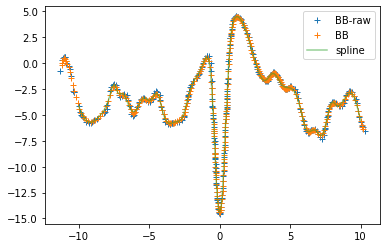

In [3]:
plt.plot(ts_bb, rate_bb, '+', label = "BB-raw")

ts_bb = gaussian_filter1d(ts_bb, 2)
rate_bb = gaussian_filter1d(rate_bb,1.5)
plt.plot(ts_bb, rate_bb, '+', label = "BB")

spl =  UnivariateSpline(ts_bb, rate_bb, s=3)
ts_lin = np.linspace(-10, 10, 300)
plt.plot(ts_lin, spl(ts_lin), '-', alpha=0.5, label="spline")
plt.legend()
#plt.xlim(-0.5, 0.5)

In [4]:
rr = 50 * br.Mohm / br.metre
A = (np.pi * (40*br.umeter)**2)
rint = br.Quantity(rr*A)
rint.in_unit(br.ohm * br.meter)

'0.25132741 ohm m'

# Simulation

## Morphology

In [43]:
def make_model(
    length=0.5*mm,
    N = 1000,
    gstar = 450 * siemens / meter**2,
    target_diameter=1*um,
    source_diameter=1*um,
    bouton_diameter=2*um,
    tip_length=-br.kmeter,
    bouton_length=-br.kmeter,
    source_rc = {
        "Cm" : 0.01 * farad / meter**2,
        "Ri" : 1.0 * ohm * meter},
    model="RTM-TM", # or HH
    trelax=0.5*ms):

    print(f"bouton: {bouton_length/um:1.2f}  tip: {tip_length/um:1.2f}")
    
    center_distance=(target_diameter+bouton_diameter)/2
    
    #######################################################
    # 1.1 Define morphology                               #
    #######################################################
    source_morpho = br.Cylinder(
        x=br.Quantity([0*mm, length]),
        diameter=source_diameter,
        n=N)
    
    # Make bouton
    bouton_mask = (source_morpho.distance > (source_morpho.distance.max() - bouton_length))
    source_morpho.diameter[bouton_mask] = bouton_diameter

    if model == "HH":
        source_model= pel.make_hh_neuron(
            morpho = source_morpho,
            **source_rc)

    elif trelax is None:
        source_model= pel.make_tasaki_neuron(
            morpho = source_morpho,
            **source_rc,
            gstar=gstar,
            g_leak_factor=1e-9)
    else:
        source_model= pel.make_repolarizing_neuron(
            morpho = source_morpho,
            **source_rc,
            trelax=trelax,
            gstar=gstar)
    
    # Make the tip not excitable
    tip_mask = (source_model.morphology.distance > (source_model.morphology.distance.max() - tip_length))

    try:
        source_model.v_threshold[tip_mask] = 10*br.kvolt
    except AttributeError:
        source_model.gNa[tip_mask] = 0 * msiemens / cm**2
        source_model.gK[tip_mask] = 0 * msiemens / cm**2
    #neuron.namespace["gNa"] = g_factor * 120 * msiemens / cm**2
        
    
    # Shift the target by a multiple of the inter compartment distance
    shift_n_compartments = (N//2) * (length/N)
    
    target_morpho = br.Cylinder(
        x=br.Quantity([0 * mm, length])+shift_n_compartments,
        y=br.Quantity([center_distance, center_distance]),
        diameter=target_diameter,
        n=source_morpho.n)
    return source_model, target_morpho


## Excecution

In [60]:
def run_model(source_model,
              target_morpho,
              I_stimulation = .01 * uamp,
              DT = 1*us, #0.1*us,
              post_stim_duration = 6 * ms,
              target_rc = {
                  "Cm" : 0.01 * farad / meter**2,
                  "Ri" : 1.0 * ohm * meter},
              sigma_ext = 1/(100 * ohm * meter)):
    ###########
    # 1.3 Run #
    ###########
    
    # Run simulation of source AP
    # pel.SPARE_CPUS = 10
    source_recording = pel.run_cable(
        source_model,
        pre_stim_duration = 1 * ms,
        post_stim_duration = post_stim_duration,
        #post_stim_duration = 4 * ms,
        I_stimulation = I_stimulation,
        stim_duration = 0.01 * ms,
        defaultclock_dt = DT,
        record_dt = DT,
        report='text')

    V_ext_t, V_ext_v = pel.calculate_V_e_Parallel(
        source_recording,
        target=target_morpho,
        sigma=sigma_ext)
    
    target_recording = pel.runImpactSimulation(
        v_ext_t=V_ext_t,
        v_ext_v=V_ext_v,
        morphology = target_morpho,
        **target_rc,
        g_leak = 1e-99 * siemens / meter**2
        )
    return source_recording, target_recording, (V_ext_t, V_ext_v)

# Run

In [16]:
datas = {}

In [61]:
def calculate(make_kws_general,
              run_kws = {"DT":.1*br.us},
              lbl=""):
    
    make_kws_a = [
     #   {},
     #   {"tip_length":15*um},
        {"bouton_length":2*um},
        {"tip_length":15*um,
         "bouton_length":2*um}
    ]
    
    #make_kws_a = [
    #    {},
    #    {"tip_length":6*um},
    #    {"bouton_length":2*um},
    #    {"tip_length":6*um,
    #     "bouton_length":2*um}
    #]
    lbl +="all1"
    
    for i, make_kws in enumerate(make_kws_a):
        print("Calculating "+str(i)+lbl)
        source_model, target_morpho = make_model(**make_kws, **make_kws_general)
        source_recording, target_recording, V_ext =  run_model(source_model, target_morpho, **run_kws)
        datas[str(i)+lbl] = source_model, target_morpho, target_recording

In [18]:
#source_model = pel.make_hh_neuron(morpho=br.Cylinder(diameter=1*br.um, n=20, length=100*br.um))
#tip_mask = (source_model.morphology.distance > (source_model.morphology.distance.max() - 10*br.um))
#source_model.gNa
run_model?

Signature:
run_model(
    source_model,
    target_morpho,
    I_stimulation=10. * namp,
    DT=1. * usecond,
    post_stim_duration=4. * msecond,
    target_rc={'Cm': 0.01 * farad / meter ** 2, 'Ri': 1. * ohm * meter},
    sigma_ext=0.01 * metre ** -3 * kilogram ** -1 * second ** 3 * amp ** 2,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_4274/2782585849.py
Type:      function


In [19]:
# HH
calculate(
    make_kws_general = {"N":1000,
                        "model":"HH"},
    run_kws={"post_stim_duration":8. * br.msecond},
    lbl="HH"
)

Calculating 0HHall1
bouton: 2.00  tip: -1000000000.00
Starting simulation at t=1.01 ms for a duration of 8. ms
8. ms (100%) simulated in 2s


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating 1HHall1
bouton: 2.00  tip: 15.00
Starting simulation at t=1.01 ms for a duration of 8. ms
8. ms (100%) simulated in 2s


  0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
# RTM standard 0.5 ms
calculate(
    make_kws_general = {"N":1000},
    lbl="RTM-0.5", 
)

Calculating 0RTM-0.5all1
bouton: 2.00  tip: -1000000000.00
Starting simulation at t=1.01 ms for a duration of 6. ms
5.5437 ms (92%) simulated in 10s, estimated 1s remaining.
6. ms (100%) simulated in 11s


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating 1RTM-0.5all1
bouton: 2.00  tip: 15.00
Starting simulation at t=1.01 ms for a duration of 6. ms
5.5437 ms (92%) simulated in 10s, estimated 1s remaining.
6. ms (100%) simulated in 11s


  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
# RTM 1.0ms
calculate(
    make_kws_general = {"N":1000, "trelax":1*br.ms},
    lbl="RTM-1.0"
)

Calculating 0RTM-1.0all1
bouton: 2.00  tip: -1000000000.00
Starting simulation at t=1.01 ms for a duration of 6. ms
5.5437 ms (92%) simulated in 10s, estimated 1s remaining.
6. ms (100%) simulated in 10s


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating 1RTM-1.0all1
bouton: 2.00  tip: 15.00
Starting simulation at t=1.01 ms for a duration of 6. ms
5.5437 ms (92%) simulated in 10s, estimated 1s remaining.
6. ms (100%) simulated in 10s


  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
# TM
calculate(
    make_kws_general = {"N":1000, "trelax":None},
    lbl="TM"
)

Calculating 0TMall1
bouton: 2.00  tip: -1000000000.00
Starting simulation at t=1.01 ms for a duration of 6. ms
6. ms (100%) simulated in 5s


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating 1TMall1
bouton: 2.00  tip: 15.00
Starting simulation at t=1.01 ms for a duration of 6. ms
6. ms (100%) simulated in 5s


  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
# RTM 2.0ms
#calculate(
#    make_kws_general = {"N":1000, "trelax":2*br.ms},
#    lbl="RTM-2.0"
#)

# Plot

In [48]:
# Plot function
def plt_morpho(ax, source_model, target_morpho, addlegend=False):
    source_morpho = source_model.morphology
    xs_s = np.array(source_morpho.x/um)
    ys_s = np.array(source_morpho.y/um)
    ds_s = np.array(source_morpho.diameter/um)
    
    tip_mask =  source_model.v_threshold > 1e2*br.volt
    source_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(xs_s[np.logical_not(tip_mask)],
                                                                  ys_s[np.logical_not(tip_mask)],
                                                                  ds_s[np.logical_not(tip_mask)])]
    
    ax.add_collection(mpl.collections.PatchCollection(source_patchs, color="red", label="Source"))    
    
    tip_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(xs_s[tip_mask],
                                                               ys_s[tip_mask],
                                                               ds_s[tip_mask])]
    
    ax.add_collection(mpl.collections.PatchCollection(tip_patchs, color="gray"))  
    
    xs_t = np.array(target_morpho.x/um)
    ys_t = np.array(target_morpho.y/um)
    ds_t = np.array(target_morpho.diameter/um)
    
    target_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(xs_t, ys_t, ds_t)]
    ln = ax.add_collection(mpl.collections.PatchCollection(target_patchs, label='Target'))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if addlegend:
        legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor='red', markersize=6, label='Source'),
                           mpl.lines.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor='#1f77b4',
                                            markersize=6, label='Target'),
                           mpl.lines.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor='gray', markersize=6, label='Non-excitable tip')]
        ax.legend(handles=legend_elements, ncol=3, frameon=False, loc="upper left",
                 bbox_to_anchor=(0, 1.2),
                 )#, handletextpad=0.1, labelspacing=0.2)
    
    ax.axis('equal')
    ax.set_xlim(xs_s.max()-15, xs_s.max()+15)
    def add_target_indicator(i, f=1, color="black"):
        target_patchs = [plt.Circle((xs_t[i], ys_t[i]), ds_t[i]*f)]
        ln = ax.add_collection(mpl.collections.PatchCollection(target_patchs, edgecolor=color, ls="-",
                                                               facecolor=(0, 0, 0, 0)))
    return add_target_indicator


RTM $0.5$ ms 496
RTM $1$ ms 496
TM 496
HH 457
_RTM $0.5$ ms 477
_RTM $1$ ms 477
_TM 477
_HH 484


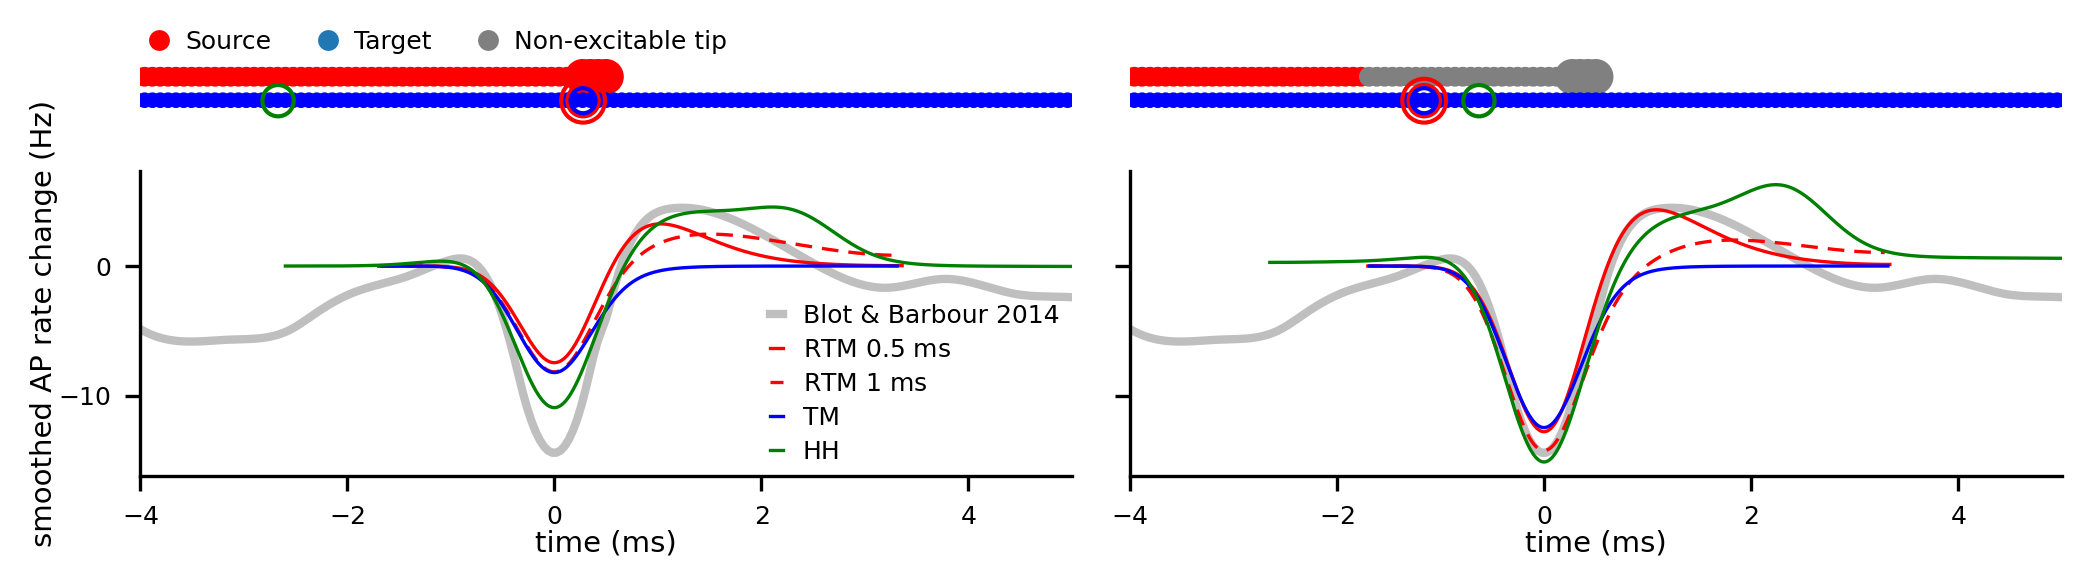

In [50]:
with mpl.rc_context(fname="plot_style.txt"):
    figsize=(17.8/2.54, 5/2.54)
    fig, AXS = plt.subplots(2, 2, figsize=figsize, sharey="row", gridspec_kw={"height_ratios":[1,3]})

    for i, (ax1, ax2) in zip([0,1], AXS.T):
        
        label_flag = "" if i == 0 else "_"
        ts = np.linspace(-6,6,300)
        ax2.plot(ts, spl(ts), alpha=0.5, color="gray", lw=2, label=label_flag+"Blot & Barbour 2014")
    
        def plot_simline(data, ax, **kwargs):
            source_model, target_morpho, target_recording = data
            
            v = np.array(target_recording.v/br.mV)
            i_x0, i_t0 = np.unravel_index(np.argmin(v), v.shape)
            
            # Simulation results
            it_1ms = int(1 / np.diff(target_recording.t/br.ms)[0])
            rate = gaussian_filter1d(target_recording.v[i_x0,:],
                                     sigma=it_1ms//(2*np.sqrt(2))
                                    )*1e3*100 # the rate change is 100Hz/mV
            ts =  target_recording.t[:len(rate)]*1e3
            ts -= ts[np.argmin(rate)]
            ax2.plot(ts, rate, **kwargs)
            print(kwargs["label"], i_x0)
            return i_x0

        # morphology plot
        data = datas[str(i)+'RTM-0.5all1']
        source_model, target_morpho, target_recording = data
        add_target_indicator = plt_morpho(ax1, source_model=source_model, target_morpho=target_morpho, addlegend=(i==0))

        cmap = plt.cm.viridis
        def cmap(x): return "red"

        post_str = "all1"

#        #RTM 0.5
        color=cmap(0)
        i_x0_a = plot_simline(data, ax2, color=color,
                              ls="-",#(0, (2.5, 3)), 
                              label=label_flag+ r'RTM $0.5$ ms')
        add_target_indicator(i_x0_a, color=color)
        
        #RTM 1
        color=cmap(0.33)
        i_x0_a = plot_simline(datas[str(i)+'RTM-1.0'+post_str], ax2, color=color,
                              ls=(0, (5, 3)),
                              label=label_flag+r'RTM $1$ ms' )
        add_target_indicator(i_x0_a, f=1.4, color=color)
        
        # TM 
        color="blue"
        i_x0_a = plot_simline(datas[str(i)+'TM'+post_str], ax2, color=color,
                              label=label_flag+"TM")
        add_target_indicator(i_x0_a, f=0.8, color=color)
        
        #HH 
        color='green'
        i_x0_a = plot_simline(datas[str(i)+'HH'+post_str], ax2, label=label_flag+"HH", color=color)
        add_target_indicator(i_x0_a, color=color)
        
        # plt settings
        ax2.set_xlim(-4, 5)
        #ax2.set_xlim(-2, 4)
        ax2.set_xlabel("time (ms)")
        if not label_flag:
            #ax2.legend(loc="lower right", reverse=False, ncol=1)
            ax2.legend(loc="lower right", ncol=1)
        
        ax1.axis("off")
        ax1.set_ylim(-1.5, 5)
        ax1.set_ylim(4, -2.5)
        
    AXS[1,0].set_ylabel("smoothed AP rate change (Hz)")
    #AXS[1,0].set_ylim(-50,30)
    plt.tight_layout()#w_pad=-2.6)
    plt.savefig("Fig-pinceau.pdf")
    plt.savefig("Fig-pinceau.svg")

RTM $0.5$ ms 490
RTM $1$ ms 490
TM 490
HH 490
_RTM $0.5$ ms 490
_RTM $1$ ms 490
_TM 490
_HH 490


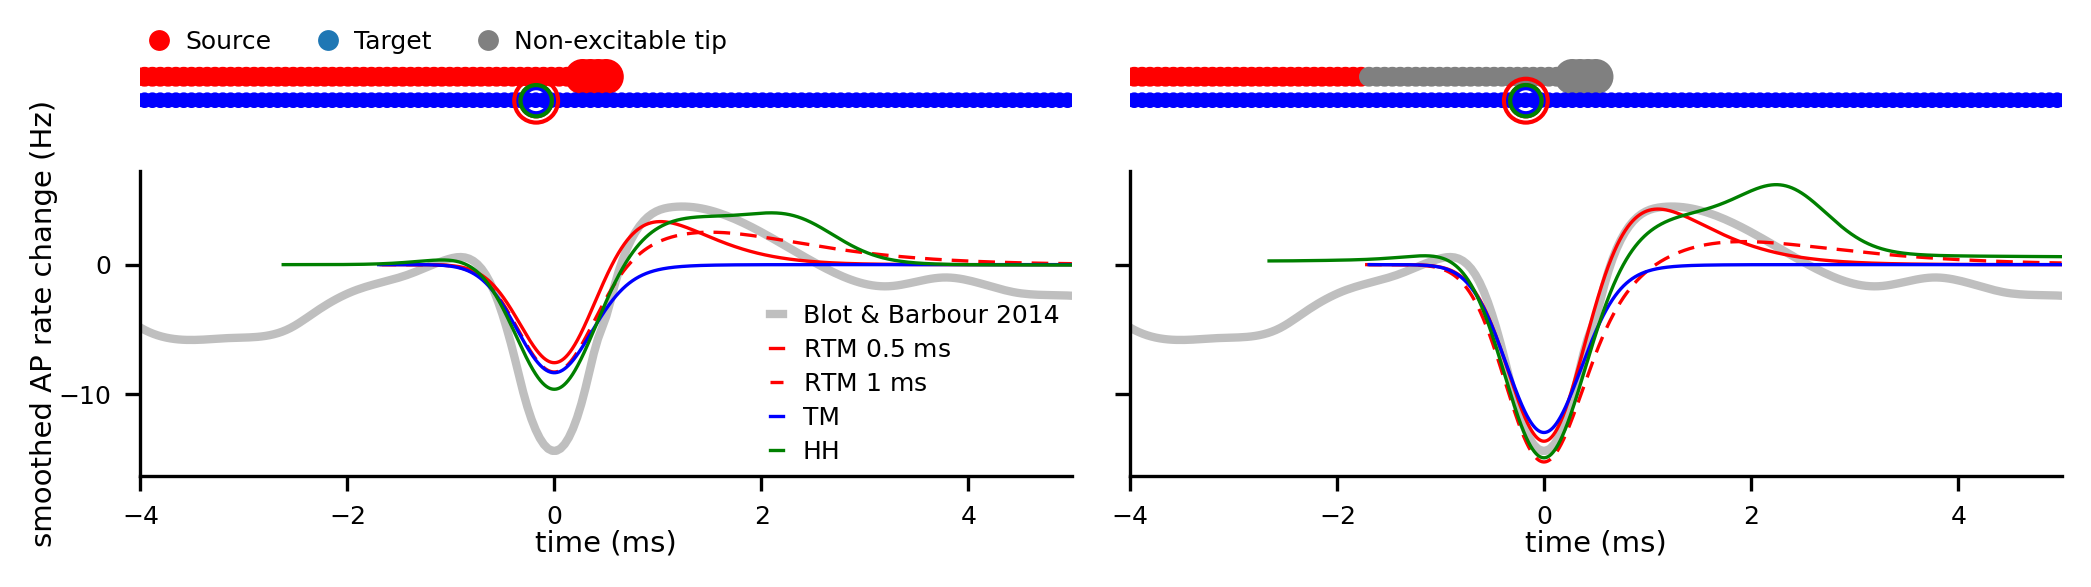

In [65]:
with mpl.rc_context(fname="plot_style.txt"):
    figsize=(17.8/2.54, 5/2.54)
    fig, AXS = plt.subplots(2, 2, figsize=figsize, sharey="row", gridspec_kw={"height_ratios":[1,3]})

    for i, (ax1, ax2) in zip([0,1], AXS.T):
        
        label_flag = "" if i == 0 else "_"
        ts = np.linspace(-6,6,300)
        ax2.plot(ts, spl(ts), alpha=0.5, color="gray", lw=2, label=label_flag+"Blot & Barbour 2014")
    
        def plot_simline(data, ax, **kwargs):
            source_model, target_morpho, target_recording = data
            
            v = np.array(target_recording.v/br.mV)
            
            # i_x0, i_t0 = np.unravel_index(np.argmin(v), v.shape)
            
            i_x0=490
            i_t0 = np.argmin(v[i_x0,:])
            
            # Simulation results
            it_1ms = int(1 / np.diff(target_recording.t/br.ms)[0])
            rate = gaussian_filter1d(target_recording.v[i_x0,:],
                                     sigma=it_1ms//(2*np.sqrt(2))
                                    )*1e3*100 # the rate change is 100Hz/mV
            ts =  target_recording.t[:len(rate)]*1e3
            ts -= ts[np.argmin(rate)]
            ax2.plot(ts, rate, **kwargs)
            print(kwargs["label"], i_x0)
            return i_x0

        # morphology plot
        data = datas[str(i)+'RTM-0.5all1']
        source_model, target_morpho, target_recording = data
        add_target_indicator = plt_morpho(ax1, source_model=source_model, target_morpho=target_morpho, addlegend=(i==0))

        cmap = plt.cm.viridis
        def cmap(x): return "red"

        post_str = "all1"

#        #RTM 0.5
        color=cmap(0)
        i_x0_a = plot_simline(data, ax2, color=color,
                              ls="-",#(0, (2.5, 3)), 
                              label=label_flag+ r'RTM $0.5$ ms')
        add_target_indicator(i_x0_a, color=color)
        
        #RTM 1
        color=cmap(0.33)
        i_x0_a = plot_simline(datas[str(i)+'RTM-1.0'+post_str], ax2, color=color,
                              ls=(0, (5, 3)),
                              label=label_flag+r'RTM $1$ ms' )
        add_target_indicator(i_x0_a, f=1.4, color=color)
        
        # TM 
        color="blue"
        i_x0_a = plot_simline(datas[str(i)+'TM'+post_str], ax2, color=color,
                              label=label_flag+"TM")
        add_target_indicator(i_x0_a, f=0.8, color=color)
        
        #HH 
        color='green'
        i_x0_a = plot_simline(datas[str(i)+'HH'+post_str], ax2, label=label_flag+"HH", color=color)
        add_target_indicator(i_x0_a, color=color)
        
        # plt settings
        ax2.set_xlim(-4, 5)
        #ax2.set_xlim(-2, 4)
        ax2.set_xlabel("time (ms)")
        if not label_flag:
            #ax2.legend(loc="lower right", reverse=False, ncol=1)
            ax2.legend(loc="lower right", ncol=1)
        
        ax1.axis("off")
        ax1.set_ylim(-1.5, 5)
        ax1.set_ylim(4, -2.5)
        
    AXS[1,0].set_ylabel("smoothed AP rate change (Hz)")
    #AXS[1,0].set_ylim(-50,30)
    plt.tight_layout()#w_pad=-2.6)
    plt.savefig("Fig-pinceau.pdf")
    plt.savefig("Fig-pinceau.svg")

_RTM $0.5$ ms 495
_RTM $1$ ms 495
_TM 495
RTM $0.5$ ms 495
RTM $1$ ms 495
TM 495


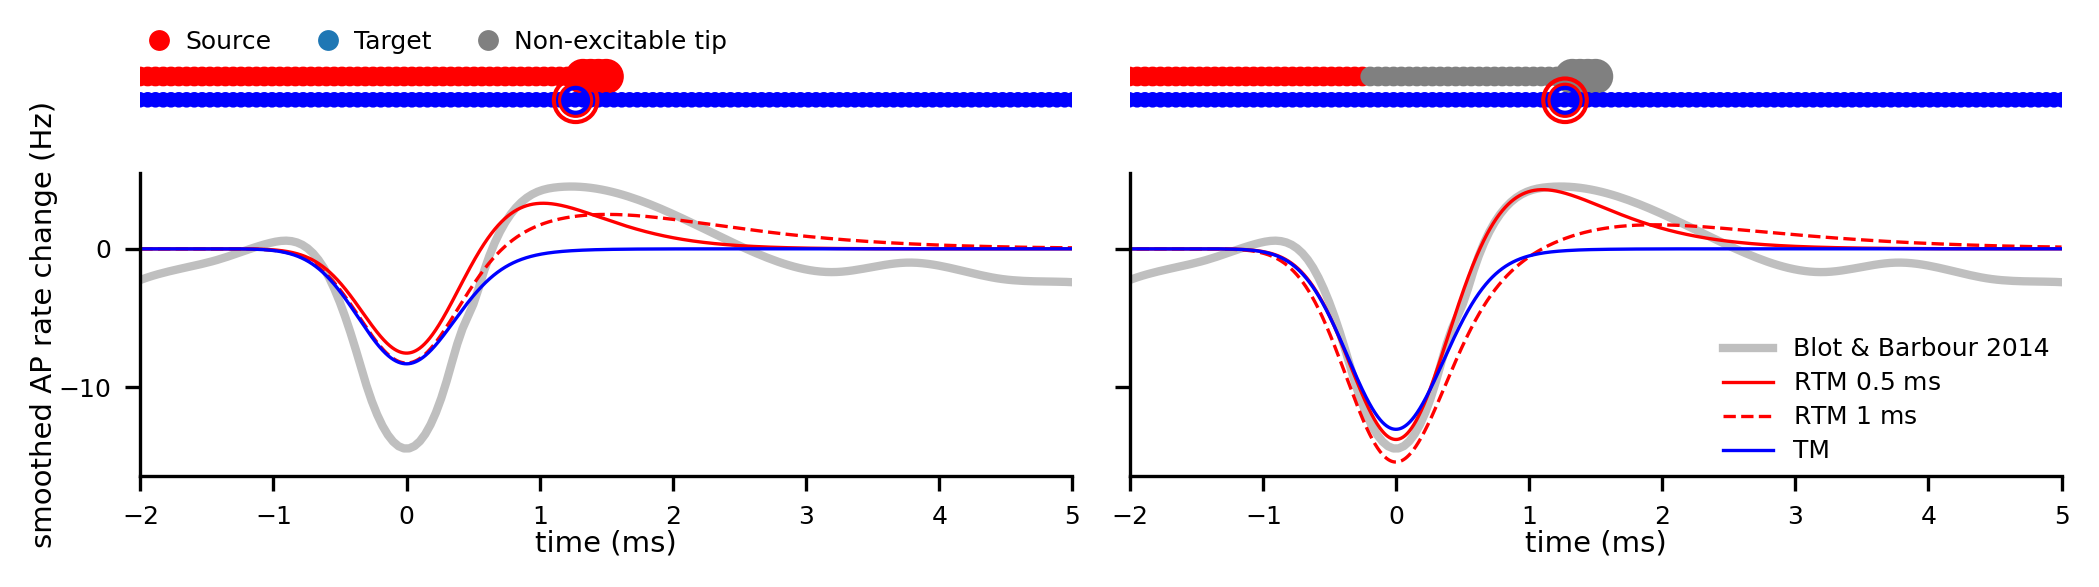

In [120]:
with mpl.rc_context(fname="plot_style.txt"):
    figsize=(17.8/2.54, 5/2.54)
    fig, AXS = plt.subplots(2, 2, figsize=figsize, sharey="row", gridspec_kw={"height_ratios":[1,3]})

    for i, (ax1, ax2) in zip([0,1], AXS.T):
        
        label_flag = "_" if i == 0 else ""
        ts = np.linspace(-6,6,300)
        ax2.plot(ts, spl(ts), alpha=0.5, color="gray", lw=2, label=label_flag+"Blot & Barbour 2014")
    
        def plot_simline(data, ax, **kwargs):
            source_model, target_morpho, target_recording = data
            
            v = np.array(target_recording.v/br.mV)
            
            # i_x0, i_t0 = np.unravel_index(np.argmin(v), v.shape)
            
            i_x0=495
            i_t0 = np.argmin(v[i_x0,:])
            
            # Simulation results
            it_1ms = int(1 / np.diff(target_recording.t/br.ms)[0])
            rate = gaussian_filter1d(target_recording.v[i_x0,:],
                                     sigma=it_1ms/(2*np.sqrt(2))
                                    )*1e3*100 # the rate change is 100Hz/mV
            ts =  target_recording.t[:len(rate)]*1e3
            ts -= ts[np.argmin(rate)]
            ax2.plot([-5, *ts], [0, *rate], **kwargs)
            print(kwargs["label"], i_x0)
            return i_x0

        # morphology plot
        data = datas[str(i)+'RTM-0.5all1']
        source_model, target_morpho, target_recording = data
        add_target_indicator = plt_morpho(ax1, source_model=source_model, target_morpho=target_morpho, addlegend=(i==0))

        cmap = plt.cm.viridis
        def cmap(x): return "red"

        post_str = "all1"

#        #RTM 0.5
        color=cmap(0)
        i_x0_a = plot_simline(data, ax2, color=color,
                              ls="-",#(0, (2.5, 3)), 
                              label=label_flag+ r'RTM $0.5$ ms')
        add_target_indicator(i_x0_a, color=color)
        
        #RTM 1
        color=cmap(0.33)
        i_x0_a = plot_simline(datas[str(i)+'RTM-1.0'+post_str], ax2, color=color,
                              ls="--",#(0, (5, 3)),
                              label=label_flag+r'RTM $1$ ms' )
        add_target_indicator(i_x0_a, f=1.4, color=color)
        
        # TM 
        color="blue"
        i_x0_a = plot_simline(datas[str(i)+'TM'+post_str], ax2, color=color,
                              label=label_flag+"TM")
        add_target_indicator(i_x0_a, f=0.8, color=color)
        
        #HH 
#        color='green'
#        i_x0_a = plot_simline(datas[str(i)+'HH'+post_str], ax2, label=label_flag+"HH", color=color)
#        add_target_indicator(i_x0_a, color=color)
        
        # plt settings
        #ax2.set_xlim(-3, 4)
        ax2.set_xlim(-2, 5)
        #ax2.set_xlim(-2, 4)
        ax2.set_xlabel("time (ms)")
        if not label_flag:
            #ax2.legend(loc="lower right", reverse=False, ncol=1)
            ax2.legend(loc="lower right", ncol=1, handlelength=2.0)
        
        ax1.axis("off")
        #ax1.set_ylim(-1.5, 5)
        ax1.set_ylim(4, -2.5)
        
    AXS[1,0].set_ylabel("smoothed AP rate change (Hz)")
    #AXS[1,0].set_ylim(-50,30)
    plt.tight_layout()#w_pad=-2.6)
    plt.savefig("Fig-pinceau.pdf")
    plt.savefig("Fig-pinceau.svg")

# Parameter review

In [ ]:
ri_bb = 150e4*br.ohm*br.um
ri_bb

gK_bb = 15e-12/120e-3 *0.4*br.siemens/(br.um**2)
gK_bb

[ncbi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8570497/)

[Sierksma21](https://doi.org/10.1371%2Fjournal.pcbi.1009527)
1 ohm m
extracellular: 0.75 Ohm m

Around Calyx of held 0.75 ohm m


Mathner Axon cap 80 ohm m in Weiss Faber [suppl](doi.org/10.1073/pnas.0806145105)


Unklar in BB inter and intra pinceau ??

 
radial throun myelin
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3055543/
"" barrett**2 say
90*br.kohm*br.meter
but they measure
1400 - 12000 * br.kohm*br.meter


LFP (long range) Linden 2011 0.3 S/m
https://www.cell.com/neuron/pdf/S0896-6273(11)01005-1.pdf


in https://arxiv.org/pdf/physics/0303057.pdf
Ranck 1963    3 Ohm m
Nunez 1981    fluid 1.6 S/m   membranes 3.5e-9 S/m


In [73]:
# Blot and Barbour
R_pinceau = 300 * br.kohm

# sphere
#R_sphere = 1/(4 * br.pi * sigma * r)
radius = 2.5 * br.umeter
sigma = 1/(4 * br.pi * R_pinceau * radius)
(1/sigma).round(1)

9.4 * ohm * meter

In [83]:
#R_shell = rho / (4*br.pi) * ((1/a) - 1/b)

a = 2.3* br.umeter
b = 2.5* br.umeter

a = 3.7* br.umeter
b = 4.0* br.umeter
rho = R_pinceau * (4*br.pi) / ((1/a) - 1/b)
rho.in_unit(br.ohm * br.meter)

rho.round(1)

186. * ohm * meter

In [108]:
thickness = 0.5*um
for radius in [1*um,
              2*um,
              4*um]:
    
    inner_rad = radius-thickness
    rho = R_pinceau * (4*br.pi) / ((1/inner_rad) - 1/radius)
    rho.in_unit(br.ohm * br.meter)
    
    A = 4 * br.pi * radius**2
    
    print(f"{radius.in_unit(br.um, 1)}  -  {A.in_unit(br.um**2, 1):^11}  -  {rho.round(1):^4}")
    

1. um  -   12.6 um^2   -  3.8 
2. um  -   50.3 um^2   -  22.6
4. um  -  201.1 um^2   -  105.6


In [115]:
for thickness in [0.25*um,
              0.5*um,
              1*um]:
    radius = 4*um
    
    inner_rad = radius-thickness
    rho = R_pinceau * (4*br.pi) / ((1/inner_rad) - 1/radius)
    rho.in_unit(br.ohm * br.meter)
    
    A = 4 * br.pi * radius**2
    
    print(f"{thickness.in_unit(br.um, 1)}  -  {A.in_unit(br.um**2, 1):^11}  -  {rho.in_unit(br.ohm*br.meter, 1)}")
    

0.2 um  -  201.1 um^2   -  226.2 ohm m
0.5 um  -  201.1 um^2   -  105.6 ohm m
1. um  -  201.1 um^2   -  45.2 ohm m


In [111]:
# Flat calculation
A = 200*br.um**2
d = 0.5*um
rho=R_pinceau*A/d
rho.round(1)

120. * ohm * meter

In [ ]:
1/0

# Scratch

In [88]:
radius = 0.4 * br.umeter
A = br.pi * radius**2
leng = 10 * br.umeter
R_ax = 30 * br.Mohm


rho =  R_ax * A / leng

rho.in_unit(br.ohm * br.meter)

'1.50796447 ohm m'

In [ ]:
# RTM standard 0.5 ms
calculate(
    make_kws_general = {"N":1000},
    run_kws = {"DT":1*br.us},
    lbl=""
)

In [ ]:
# RTM standard 0.5 ms
make_kws_general = {"N":1000}
run_kws_general = {"DT":1*br.us} 
for make_kws, run_kws, lbl in [
    [make_kws_general,
     run_kws_general, "1"],
    [{**make_kws_general,
      "tip_length":10*um},
     run_kws_general, "2"],
    [{**make_kws_general,
      "tip_length":10*um,
      "bouton_length":2*um},
     run_kws_general, "3",
    ]]:
    
    print(lbl, end=": ")
    source_model, target_morpho = make_model(**make_kws)
    source_recording, target_recording, V_ext =  run_model(source_model, target_morpho, **run_kws)
    datas[lbl] = source_model, target_morpho, target_recording

In [ ]:
 
make_kws_general = {"N":1000,
                    "trelax":None}
run_kws_general = {"DT":1*br.us} 
for make_kws, run_kws, lbl in [
    [make_kws_general,
     run_kws_general, "1tc"],
    [{**make_kws_general,
      "tip_length":10*um},
     run_kws_general, "2tc"],
    [{**make_kws_general,
      "tip_length":10*um,
      "bouton_length":2*um},
     run_kws_general, "3tc"]
]:
    
    print(lbl, end=": ")
    source_model, target_morpho = make_model(**make_kws)
    source_recording, target_recording, V_ext =  run_model(source_model, target_morpho, **run_kws)

    datas[lbl] = source_model, target_morpho, target_recording

In [ ]:
 
make_kws_general = {"N":1000,
                    "trelax":1.5*br.ms}
run_kws_general = {"DT":1*br.us} 
for make_kws, run_kws, lbl in [
    [make_kws_general,
     run_kws_general, "1-1ms"],
    [{**make_kws_general,
      "tip_length":10*um},
     run_kws_general, "2-1ms"],
    [{**make_kws_general,
      "tip_length":10*um,
      "bouton_length":2*um},
     run_kws_general, "3-1ms"]
]:
    
    print(lbl, end=": ")
    source_model, target_morpho = make_model(**make_kws)
    source_recording, target_recording, V_ext =  run_model(source_model, target_morpho, **run_kws)

    datas[lbl] = source_model, target_morpho, target_recording

In [ ]:
def do_plt(ax1, ax2, source_model, target_morpho, target_recording, add_legend=False, ln_label=""):
    add_target_indicator = plt_morpho(ax1, source_model=source_model, target_morpho=target_morpho, addlegend=add_legend)
    ax1.axis("off")
    
    v = np.array(target_recording.v/br.mV)
    i_x0, i_t0 = np.unravel_index(np.argmin(v), v.shape)
    add_target_indicator(i_x0)

    if ln_label == "":
        label = "RTM plain"
        bb_label = "Blot & Barbour 2014"
    else:
        label = ln_label
        bb_label = "_bb"
    
    ts = np.linspace(-6,6,300)
    ax2.plot(ts, spl(ts), alpha=0.4, color="gray", lw=5, label=bb_label)

    it_1ms = int(1 / np.diff(target_recording.t/br.ms)[0])
    rate = gaussian_filter1d(target_recording.v[i_x0,:],
                             sigma=it_1ms//(2*np.sqrt(2))
    # the rate change is 100Hz/mV
                            )*1e3*100
    ts =  target_recording.t[:len(rate)]*1e3
    ts -= ts[np.argmin(rate)]
    
    ax2.plot(ts, rate, label=label)
    ax2.set_xlim(-3, 5)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8,4), gridspec_kw={"height_ratios":[1,3]})
do_plt(*axs, source_model, target_morpho, target_recording, 1)

In [ ]:
 
    for (lbl, ), a, add_legend, ln_label in zip(datas.items(),
                                                                                               AXS.T,
                                                                                               [1,0,0],
                                                                                               ["",
                                                                                                "RTM with:\nnon-excitable end",
                                                                                                "RTM with:\nnon-excitable end,\nbouton"]):
        #print(lbl, a)
        
        #do_plt(*a, source_model, target_morpho, target_recording, add_legend=add_legend, ln_label=ln_label)

    
    
        if ln_label == "":
            label = "RTM plain"

        
        
    
    

In [ ]:
with mpl.rc_context(fname="plot_style.txt"):
    figsize=(17.8/2.54, 5/2.54)
    
    fig, AXS = plt.subplots(2, 3, figsize=figsize, sharey="row", gridspec_kw={"height_ratios":[1,3]})
    for (lbl, (source_model, target_morpho, target_recording)), a, add_legend, ln_label in zip(datas.items(),
                                                                                               AXS.T,
                                                                                               [1,0,0],
                                                                                               ["",
                                                                                                "RTM with:\nnon-excitable end",
                                                                                                "RTM with:\nnon-excitable end,\nbouton"]):
        do_plt(*a, source_model, target_morpho, target_recording, add_legend=add_legend, ln_label=ln_label)

        ax1, ax2 = a
        ax1.set_ylim(-1.5, 5)
        ax2.set_xlabel("time (ms)")
        ax2.legend(loc="lower right")
        
    
    AXS[1,0].set_ylabel("smoothed AP rate change (Hz)")
    plt.tight_layout(w_pad=-1.3)
    